<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/ep_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# For readability

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '28px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# Replicate the EP model  
https://opensourcefootball.com/posts/2020-09-28-nflfastr-ep-wp-and-cp-models/

## gpu install

In [ ]:
!pip uninstall lightgbm -y
!git clone --recursive https://github.com/Microsoft/LightGBM
!apt-get install -y -qq libboost-all-dev

<IPython.core.display.Javascript object>

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Cloning into 'LightGBM'...
remote: Enumerating objects: 23948, done.
remote: Counting objects: 100% (1624/1624), done.
remote: Compressing objects: 100% (933/933), done.
remote: Total 23948 (delta 1010), reused 1103 (delta 655), pack-reused 22324
Receiving objects: 100% (23948/23948), 19.48 MiB | 28.61 MiB/s, done.
Resolving deltas: 100% (17403/17403), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compu

In [ ]:
%%bash
cd LightGBM
rm -rf build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

<IPython.core.display.Javascript object>

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - not found
-- Looking for CL_VERSION_2_1
-- Looking for CL_VERSION_2_1 - not found
-- Looking for CL_VERSION_2_0
-- Looking for CL_VERSION_2_0 - not found
-- Looking for CL_VERSION_1_2
-- Looking

In [ ]:
!cd LightGBM/python-package/;python3 setup.py install --precompile
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM
!pip install optgbm

<IPython.core.display.Javascript object>

running install
running build
running build_py
INFO:root:Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/dask.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
writing manifest f

## data load in

In [ ]:
# !apt install subversion --quiet
# !svn export https://github.com/guga31bb/nflfastR-data/trunk/data "/content/drive/My Drive/nflfastR-data/data" --force --quiet


<IPython.core.display.Javascript object>

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error
from sklearn.model_selection import GroupKFold
from scipy.stats import pearsonr
import optuna.integration.lightgbm as lgb
import lightgbm as lgb_vanilla

from urllib.request import urlopen
import itertools
import warnings

<IPython.core.display.Javascript object>

In [ ]:
schedule = pd.read_csv('https://github.com/nflverse/nfldata/blob/master/data/games.csv?raw=true')
schedule_21 = schedule.loc[schedule['season']==2021]
roster = pd.read_csv('https://github.com/nflverse/nflfastR-roster/blob/master/data/seasons/roster_2021.csv?raw=true')
qbs = roster.loc[(roster['depth_chart_position']=='QB') & (roster['status']=='Active')]
qbs['passer_player_name'] = qbs['first_name'].str[0].add('.').add(qbs['last_name'])

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
warnings.filterwarnings('ignore')
project_dir = 'drive/My Drive/nflfastR-data'
fns = [f"{project_dir}/data/{x}" for x in os.listdir(f"{project_dir}/data") if (".csv" in x) and ("play_by_play" in x)]
df = pd.DataFrame()
for fn in tqdm(fns):
  try:
    _df = pd.read_csv(fn, compression='gzip')
    df = df.append(_df, ignore_index=True)
  except:
    print('lol get rekt')
    continue

df['is_home'] = df['posteam_type'].replace(['home', 'away', None], [1,0,0])
df['distance_to_sticks'] = df['air_yards'].sub(df['ydstogo'])
df['era'] = '1999-2001'
df.loc[df['season'].between(2002,2005), 'era'] = '2002-2005'
df.loc[df['season'].between(2006,2013), 'era'] = '2006-2013'
df.loc[df['season'].between(2014,2017), 'era'] = '2014-2017'
df.loc[df['season']>=2018, 'era'] = '2018-current'

df['is_air_yards_zero'] = 1
df.loc[df['air_yards']>0, 'is_air_yards_zero'] = 0

df['is_pass_loc_middle'] = df['pass_location'].replace(['right', 'left', 'middle'], [0,0,1])

df['drive_event'] = (df['fixed_drive_result'].fillna('No Score')
                     .replace(['Punt', 'Touchdown', 'Turnover', 'Field goal',
                               'Turnover on downs', 'End of half',
                               'Missed field goal', 'Opp touchdown', 'Safety'],
                              ['No Score', 'Touchdown', 'No Score',
                               'Field goal', 'No Score', 'No Score', 'No Score',
                               'Opp Touchdown', 'Safety']))

cols = ['defteam', 'roof', 'era', 'drive_event']
for col in cols:
  df[f'{col}_code'] = df[col].astype('category').cat.codes

df['pos_coach'] = df['home_coach']
df.loc[df['is_home']==0, 'pos_coach'] = df.loc[df['is_home']==0, 'away_coach']

df['fg'] = df['field_goal_result'].replace(['made', 'blocked', 'missed'], [1,0,0]).fillna(0)
df['scoring_play'] = df.loc[:, ['touchdown', 'fg', 'safety']].sum(axis=1)
df['scoring_desc'] = df.loc[:, ['touchdown', 'fg', 'safety']].idxmax(axis=1)
df.loc[(df['qtr'].isin([2, 4, 5]))&((df['quarter_end']==1) | (df['desc'].str.contains('END GAME')) |(df['desc'].str.contains('END QUARTER 2'))), 'scoring_desc'] = 'no_score'
df.loc[(df['scoring_play']==0) & (df['scoring_desc']!='no_score'), 'scoring_desc'] = np.nan
_df = df.loc[(df['scoring_play']==1) | (df['scoring_desc']=='no_score'), ['game_id', 'play_id', 'scoring_desc','posteam', 'defteam', 'posteam_score', 'posteam_score_post', 'defteam_score', 'defteam_score_post']]
_df['next_score_team'] = np.nan
_df.loc[_df['posteam_score']!=_df['posteam_score_post'], 'next_score_team'] = _df.loc[_df['posteam_score']!=_df['posteam_score_post'], 'posteam']
_df.loc[_df['defteam_score']!=_df['defteam_score_post'], 'next_score_team'] = _df.loc[_df['defteam_score']!=_df['defteam_score_post'], 'defteam']
_df['wtf'] = _df.loc[:, ['posteam_score', 'posteam_score_post', 'defteam_score', 'defteam_score_post']].isnull().sum(axis=1)
_df.loc[(_df['wtf']==2) & (_df['posteam_score_post']>0), 'next_score_team'] = _df.loc[(_df['wtf']==2) & (_df['posteam_score_post']>0), 'posteam']
_df.loc[(_df['wtf']==2) & (_df['defteam_score_post']>0), 'next_score_team'] = _df.loc[(_df['wtf']==2) & (_df['defteam_score_post']>0), 'defteam']
_df.loc[_df['wtf']==4, 'next_score_team'] = np.nan
df['next_score_desc'] = _df['scoring_desc']
df['next_score_team'] = _df['next_score_team']
df.loc[:, ['next_score_team', 'next_score_desc']] = df.loc[:, ['next_score_team', 'next_score_desc']].fillna(method='bfill')
df.loc[df['scoring_desc']=='no_score', 'next_score_team'] = np.nan
df['opp'] = ''
df.loc[df['posteam']!=df['next_score_team'], 'opp'] = 'opp_'
df['next_score_target'] = df['opp'].add(df['next_score_desc']).replace('opp_no_score', 'no_score')
df['next_score_target_code'] = df['next_score_target'].astype('category').cat.codes
warnings.filterwarnings('default')
df.shape

<IPython.core.display.Javascript object>

  0%|          | 0/23 [00:00<?, ?it/s]

(1069741, 391)

# Expected points (EP) model features
* Seconds remaining in half  
* Yard line  
* Whether possession team is at home  
* Roof type: retractable, dome, or outdoors  
* Down  
* Yards to go  
* Era: 1999-2001 (pre-expansion), 2002-2005 (pre-CPOE), 2006-2013 (pre-LOB rules change), 2014-2017, 2018 and beyond  
* Timeouts remaining for each team  

In [ ]:
feats = ['half_seconds_remaining', 'yardline_100', 'is_home', 'roof_code',
         'down', 'ydstogo', 'era_code', 'posteam_timeouts_remaining',
         'defteam_timeouts_remaining']
target = 'next_score_target_code'

<IPython.core.display.Javascript object>

In [ ]:
model_data = df.dropna(subset=feats+['play_id', 'game_id', target]).loc[:, ['play_id', 'game_id', target, 'season']+feats]
model_data.shape

<IPython.core.display.Javascript object>

(890347, 13)

In [ ]:
train_seasons = random.sample(range(1999,2021), 5)
test_seasons = random.sample([x for x in range(1999,2021) if x not in train_seasons], 2)
train_data = model_data.loc[model_data['season'].isin(train_seasons)]
test_data = model_data.loc[model_data['season'].isin(test_seasons)]

lgb_train = lgb.Dataset(train_data.loc[:, feats], train_data[target], free_raw_data=False)
lgb_test = lgb.Dataset(test_data.loc[:, feats], test_data[target], free_raw_data=False)

df_pred = pd.DataFrame()
p = dict(objective='multiclass',
         metric='softmax',
         learning_rate=0.1,
         num_class=df[target].unique().shape[0],
         max_bin=63,
         device = 'gpu',
         gpu_platform_id = 0,
         gpu_device_id = 0,
         num_thread = 28,)

model = lgb.LightGBMTuner(p,lgb_train,num_boost_round=4000,
                          valid_sets=lgb_test, early_stopping_rounds=200,
                          verbose_eval=1000, verbosity=0, time_budget=12*60*60)
model.run()

feature_fraction, val_score: 1.298244:  57%|#####7    | 4/7 [08:40<06:43, 134.40s/it]

Early stopping, best iteration is:
[118]	valid_0's multi_logloss: 1.30296


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003947 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

feature_fraction, val_score: 1.296782:  71%|#######1  | 5/7 [10:45<04:22, 131.26s/it]

Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 1.29678


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004104 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

feature_fraction, val_score: 1.296782:  86%|########5 | 6/7 [12:50<02:09, 129.05s/it]

Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 1.29678
[LightGBM] [Info] This is the GPU trainer!!


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003702 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 1.296782: 100%|##########| 7/7 [14:47<00:00, 126.86s/it]


Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 1.29844


num_leaves, val_score: 1.296782:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004338 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 1.296782:   5%|5         | 1/20 [07:57<2:31:05, 477.12s/it]

Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 1.30724


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004067 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.296782:  10%|#         | 2/20 [09:40<1:17:15, 257.55s/it]

Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 1.29709
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003699 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 1.296782:  15%|#5        | 3/20 [12:23<1:00:42, 214.29s/it]

Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 1.29923


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002802 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.296782:  20%|##        | 4/20 [25:01<1:54:18, 428.64s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003294 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.296782:  25%|##5       | 5/20 [34:56<2:02:13, 488.92s/it]

Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 1.30947


num_leaves, val_score: 1.296782:  25%|##5       | 5/20 [34:56<2:02:13, 488.92s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002675 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.296782:  30%|###       | 6/20 [40:58<1:43:59, 445.71s/it]

Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 1.30508


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002864 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.296782:  35%|###5      | 7/20 [48:35<1:37:22, 449.46s/it]

Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 1.30724


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003993 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.296782:  40%|####      | 8/20 [57:16<1:34:23, 471.99s/it]

Early stopping, best iteration is:
[42]	valid_0's multi_logloss: 1.30817


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003689 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.296782:  45%|####5     | 9/20 [1:02:57<1:19:03, 431.20s/it]

Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 1.30463


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003682 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.296782:  50%|#####     | 10/20 [1:09:37<1:10:16, 421.68s/it]

Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 1.30632


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004241 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.294923:  55%|#####5    | 11/20 [1:10:44<46:57, 313.08s/it]

Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 1.29492
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003902 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 1.294923:  60%|######    | 12/20 [1:12:03<32:14, 241.79s/it]

Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 1.29571
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002764 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 1.294923:  65%|######5   | 13/20 [1:15:37<27:14, 233.47s/it]

Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 1.3008


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002679 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.294325:  70%|#######   | 14/20 [1:16:28<17:49, 178.18s/it]

Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 1.29433
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004151 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 1.293076:  75%|#######5  | 15/20 [1:17:11<11:28, 137.65s/it]

Early stopping, best iteration is:
[223]	valid_0's multi_logloss: 1.29308


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003015 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.293076:  80%|########  | 16/20 [1:21:03<11:03, 165.97s/it]

Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 1.30084


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002624 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.293076:  85%|########5 | 17/20 [1:25:40<09:58, 199.35s/it]

Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 1.30295


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002842 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.293076:  90%|######### | 18/20 [1:26:22<05:04, 152.12s/it]

Early stopping, best iteration is:
[576]	valid_0's multi_logloss: 1.30395


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004010 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

num_leaves, val_score: 1.293076:  95%|#########5| 19/20 [1:29:17<02:38, 158.83s/it]

Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 1.29944


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003685 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
Training until validation scores don't i

bagging, val_score: 1.293076:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002685 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin 

bagging, val_score: 1.293076:  10%|#         | 1/10 [00:51<07:40, 51.15s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29335
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003732 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002706 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

bagging, val_score: 1.293013:  20%|##        | 2/10 [01:39<06:37, 49.74s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29301
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002941 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.97 MB) transferred to GPU in 0.002164 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

bagging, val_score: 1.293013:  30%|###       | 3/10 [02:24<05:31, 47.35s/it]

Early stopping, best iteration is:
[175]	valid_0's multi_logloss: 1.29341
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003030 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.92 MB) transferred to GPU in 0.001981 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

bagging, val_score: 1.293013:  40%|####      | 4/10 [03:13<04:49, 48.21s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29337
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002841 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.85 MB) transferred to GPU in 0.002072 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

bagging, val_score: 1.293013:  50%|#####     | 5/10 [04:08<04:11, 50.39s/it]

Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 1.29314


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002697 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin 

bagging, val_score: 1.293013:  60%|######    | 6/10 [05:04<03:30, 52.53s/it]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002914 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin 

bagging, val_score: 1.293013:  70%|#######   | 7/10 [05:51<02:31, 50.64s/it]

Early stopping, best iteration is:
[204]	valid_0's multi_logloss: 1.29378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002842 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.22 MB) transferred to GPU in 0.002427 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

bagging, val_score: 1.293013:  80%|########  | 8/10 [06:40<01:40, 50.11s/it]

Early stopping, best iteration is:
[206]	valid_0's multi_logloss: 1.29306
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004027 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.32 MB) transferred to GPU in 0.003439 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

bagging, val_score: 1.293013:  90%|######### | 9/10 [07:34<00:51, 51.26s/it]

Early stopping, best iteration is:
[224]	valid_0's multi_logloss: 1.29325


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004008 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin 

bagging, val_score: 1.293013: 100%|##########| 10/10 [08:23<00:00, 50.39s/it]


[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.31 MB) transferred to GPU in 0.002548 secs. 1 sparse feature groups
Early stopping, best iteration is:
[203]	valid_0's multi_logloss: 1.29338


feature_fraction_stage2, val_score: 1.293013:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002886 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin 

feature_fraction_stage2, val_score: 1.293013:  17%|#6        | 1/6 [00:46<03:54, 46.86s/it]

Early stopping, best iteration is:
[195]	valid_0's multi_logloss: 1.29352
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003640 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002799 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

feature_fraction_stage2, val_score: 1.293013:  33%|###3      | 2/6 [01:33<03:06, 46.73s/it]

Early stopping, best iteration is:
[195]	valid_0's multi_logloss: 1.29352
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004709 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002523 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

feature_fraction_stage2, val_score: 1.293013:  50%|#####     | 3/6 [02:22<02:23, 47.99s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29301
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002831 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002527 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

feature_fraction_stage2, val_score: 1.293013:  67%|######6   | 4/6 [03:12<01:36, 48.41s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29301
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004053 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002140 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

feature_fraction_stage2, val_score: 1.293013:  83%|########3 | 5/6 [03:58<00:47, 47.83s/it]

Early stopping, best iteration is:
[195]	valid_0's multi_logloss: 1.2935
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002694 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002485 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

feature_fraction_stage2, val_score: 1.293013: 100%|##########| 6/6 [04:47<00:00, 47.98s/it]


Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29301


regularization_factors, val_score: 1.293013:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004360 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002055 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.293013:   5%|5         | 1/20 [00:49<15:32, 49.10s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29304
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002979 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.001987 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292979:  10%|#         | 2/20 [01:38<14:46, 49.24s/it]

Early stopping, best iteration is:
[220]	valid_0's multi_logloss: 1.29298
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004449 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002182 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292979:  15%|#5        | 3/20 [02:27<13:56, 49.23s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29301
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003149 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002243 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292979:  20%|##        | 4/20 [03:17<13:08, 49.30s/it]

Early stopping, best iteration is:
[220]	valid_0's multi_logloss: 1.29315
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003665 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.001969 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292979:  25%|##5       | 5/20 [04:06<12:19, 49.27s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29304
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003704 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002123 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292979:  30%|###       | 6/20 [04:55<11:31, 49.37s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29301
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003873 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002683 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292979:  35%|###5      | 7/20 [05:45<10:41, 49.37s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29316
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002790 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002660 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292979:  40%|####      | 8/20 [06:34<09:52, 49.42s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.2934
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003682 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002671 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292979:  45%|####5     | 9/20 [07:24<09:03, 49.41s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29315
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003848 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.001886 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292979:  50%|#####     | 10/20 [08:13<08:14, 49.49s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29321
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002917 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002634 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292979:  55%|#####5    | 11/20 [09:03<07:24, 49.41s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29301
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003867 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002564 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292979:  60%|######    | 12/20 [09:52<06:35, 49.39s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29301
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002842 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002008 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292979:  65%|######5   | 13/20 [10:41<05:46, 49.44s/it]

Early stopping, best iteration is:
[220]	valid_0's multi_logloss: 1.293
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.004014 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.001985 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292803:  70%|#######   | 14/20 [11:31<04:56, 49.34s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.2928
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002932 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002873 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292803:  75%|#######5  | 15/20 [12:20<04:06, 49.33s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29292
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003032 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002652 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292803:  80%|########  | 16/20 [13:09<03:17, 49.41s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29296
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003672 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002567 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292803:  85%|########5 | 17/20 [13:59<02:28, 49.58s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29336
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002863 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002678 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292803:  90%|######### | 18/20 [14:49<01:39, 49.58s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29324
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002817 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002518 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292803:  95%|#########5| 19/20 [15:39<00:49, 49.60s/it]

Early stopping, best iteration is:
[220]	valid_0's multi_logloss: 1.29323
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002668 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002792 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

regularization_factors, val_score: 1.292758: 100%|##########| 20/20 [16:28<00:00, 49.44s/it]


Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29276


min_data_in_leaf, val_score: 1.292758:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003690 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature g

min_data_in_leaf, val_score: 1.292758:  20%|##        | 1/5 [00:49<03:18, 49.62s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29294
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002784 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.001981 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

min_data_in_leaf, val_score: 1.292758:  40%|####      | 2/5 [01:39<02:29, 49.79s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29312
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002784 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002821 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

min_data_in_leaf, val_score: 1.292758:  60%|######    | 3/5 [02:29<01:39, 49.75s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29314
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.002874 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002736 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

min_data_in_leaf, val_score: 1.292758:  80%|########  | 4/5 [03:18<00:49, 49.68s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29299
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 197628, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (1.51 MB) transferred to GPU in 0.003792 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.365106
[LightGBM] [Info] Start training from score -1.901895
[LightGBM] [Info] Start training from score -2.276850
[LightGBM] [Info] Start training from score -5.812326
[LightGBM] [Info] Start training from score -1.850047
[LightGBM] [Info] Start training from score -5.688358
[LightGBM] [Info] Start training from score -1.111246
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.94 MB) transferred to GPU in 0.002025 secs. 1 sparse feature groups
Training until validation scores don't improve for 200 rounds
[LightGBM] [Info] Size of histogram bin entry: 8

min_data_in_leaf, val_score: 1.292758: 100%|##########| 5/5 [04:08<00:00, 49.65s/it]

Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 1.29282


In [ ]:
nrounds <- 525
params <-
  list(
    booster = "gbtree",
    objective = "multi:softprob",
    eval_metric = c("mlogloss"),
    num_class = 7,
    eta = 0.025,
    gamma = 1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    max_depth = 5,
    min_child_weight = 1
  )

In [ ]:
model.best_params

<IPython.core.display.Javascript object>

{'bagging_fraction': 0.6219188539162381,
 'bagging_freq': 5,
 'device': 'gpu',
 'feature_fraction': 0.52,
 'feature_pre_filter': False,
 'gpu_device_id': 0,
 'gpu_platform_id': 0,
 'lambda_l1': 0.00012179842476479819,
 'lambda_l2': 0.0031248623589972793,
 'learning_rate': 0.1,
 'max_bin': 63,
 'metric': 'multi_logloss',
 'min_child_samples': 20,
 'num_class': 7,
 'num_leaves': 5,
 'num_thread': 28,
 'objective': 'multiclass'}

In [ ]:
df_pred = pd.DataFrame()
model_params = {'bagging_fraction': 0.7534798209117458,
 'bagging_freq': 6,
 'device': 'gpu',
 'feature_fraction': 0.62,
 'feature_pre_filter': False,
 'gpu_device_id': 0,
 'gpu_platform_id': 0,
 'lambda_l1': 8.974565837026697,
 'lambda_l2': 1.5153053314899024e-08,
 'learning_rate': 0.1,
 'max_bin': 63,
 'metric': 'multi_logloss',
 'min_child_samples': 100,
 'num_class': 7,
 'num_leaves': 3,
 'num_thread': 28,
 'objective': 'multiclass'}

col_names = (df
             .loc[:, ['next_score_target', 'next_score_target_code']]
             .drop_duplicates()
             .sort_values('next_score_target_code')['next_score_target']
             .values)

p = model_params
for season in tqdm(model_data['season'].unique()):
  train_data = model_data.loc[model_data['season']!=season]
  test_data = model_data.loc[model_data['season']==season]

  lgb_train = lgb_vanilla.Dataset(train_data.loc[:, feats], train_data[target])
  lgb_test = lgb_vanilla.Dataset(test_data.loc[:, feats], test_data[target])
  _model = lgb_vanilla.train(p,lgb_train,num_boost_round=4000, valid_sets=lgb_test, early_stopping_rounds=200, verbose_eval=0)
  _test_data = pd.DataFrame(_model.predict(test_data.loc[:, feats]), index=test_data.index, columns=col_names)
  for col in col_names:
    test_data[f"{col}_pred"] = _test_data[col]
  df_pred = df_pred.append(test_data)

df_pred.to_csv(f'drive/My Drive/ep-replication/df_pred.csv', index=False)
df_pred.shape

<IPython.core.display.Javascript object>

  0%|          | 0/23 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 851247, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.008917 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.368728
[LightGBM] [Info] Start training from score -1.911183
[LightGBM] [Info] Start training from score -2.292169
[LightGBM] [Info] Start training from score -5.803964
[LightGBM] [Info] Start training from score -1.857015
[LightGBM] [Info] Start training from score -5.634187
[LightGBM] [Info] Start training from score -1.096943
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 852048, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.50 MB) transferred to GPU in 0.013432 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.367234
[LightGBM] [Info] Start training from score -1.913021
[LightGBM] [Info] Start training from score -2.287637
[LightGBM] [Info] Start training from score -5.775350
[LightGBM] [Info] Start training from score -1.857361
[LightGBM] [Info] Start training from score -5.612377
[LightGBM] [Info] Start training from score -1.098982
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 852157, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.50 MB) transferred to GPU in 0.009423 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.368819
[LightGBM] [Info] Start training from score -1.910846
[LightGBM] [Info] Start training from score -2.290869
[LightGBM] [Info] Start training from score -5.767942
[LightGBM] [Info] Start training from score -1.856159
[LightGBM] [Info] Start training from score -5.615401
[LightGBM] [Info] Start training from score -1.098353
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 850291, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.009251 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.366622
[LightGBM] [Info] Start training from score -1.906602
[LightGBM] [Info] Start training from score -2.285319
[LightGBM] [Info] Start training from score -5.772530
[LightGBM] [Info] Start training from score -1.859487
[LightGBM] [Info] Start training from score -5.610313
[LightGBM] [Info] Start training from score -1.102070
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 850644, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.013409 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.368057
[LightGBM] [Info] Start training from score -1.911038
[LightGBM] [Info] Start training from score -2.290519
[LightGBM] [Info] Start training from score -5.792793
[LightGBM] [Info] Start training from score -1.855396
[LightGBM] [Info] Start training from score -5.630197
[LightGBM] [Info] Start training from score -1.098923
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 850787, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.013420 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.364634
[LightGBM] [Info] Start training from score -1.909245
[LightGBM] [Info] Start training from score -2.286434
[LightGBM] [Info] Start training from score -5.790266
[LightGBM] [Info] Start training from score -1.858674
[LightGBM] [Info] Start training from score -5.625136
[LightGBM] [Info] Start training from score -1.102129
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 850567, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.013614 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.370111
[LightGBM] [Info] Start training from score -1.908083
[LightGBM] [Info] Start training from score -2.295085
[LightGBM] [Info] Start training from score -5.761206
[LightGBM] [Info] Start training from score -1.853751
[LightGBM] [Info] Start training from score -5.609032
[LightGBM] [Info] Start training from score -1.098582
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 851120, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.013621 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.370622
[LightGBM] [Info] Start training from score -1.908123
[LightGBM] [Info] Start training from score -2.291694
[LightGBM] [Info] Start training from score -5.770862
[LightGBM] [Info] Start training from score -1.855235
[LightGBM] [Info] Start training from score -5.609361
[LightGBM] [Info] Start training from score -1.098410
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 851250, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.013370 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.369097
[LightGBM] [Info] Start training from score -1.911027
[LightGBM] [Info] Start training from score -2.285949
[LightGBM] [Info] Start training from score -5.780483
[LightGBM] [Info] Start training from score -1.854291
[LightGBM] [Info] Start training from score -5.622101
[LightGBM] [Info] Start training from score -1.100245
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 851670, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.50 MB) transferred to GPU in 0.008983 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.371907
[LightGBM] [Info] Start training from score -1.904304
[LightGBM] [Info] Start training from score -2.289103
[LightGBM] [Info] Start training from score -5.795155
[LightGBM] [Info] Start training from score -1.852985
[LightGBM] [Info] Start training from score -5.639297
[LightGBM] [Info] Start training from score -1.100432
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 850971, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.012020 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.368589
[LightGBM] [Info] Start training from score -1.906080
[LightGBM] [Info] Start training from score -2.290892
[LightGBM] [Info] Start training from score -5.767676
[LightGBM] [Info] Start training from score -1.856202
[LightGBM] [Info] Start training from score -5.622748
[LightGBM] [Info] Start training from score -1.100546
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 850741, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.009427 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.368513
[LightGBM] [Info] Start training from score -1.903867
[LightGBM] [Info] Start training from score -2.288916
[LightGBM] [Info] Start training from score -5.767030
[LightGBM] [Info] Start training from score -1.856661
[LightGBM] [Info] Start training from score -5.610842
[LightGBM] [Info] Start training from score -1.102118
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 850211, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.008923 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.371031
[LightGBM] [Info] Start training from score -1.906611
[LightGBM] [Info] Start training from score -2.290033
[LightGBM] [Info] Start training from score -5.780023
[LightGBM] [Info] Start training from score -1.855286
[LightGBM] [Info] Start training from score -5.644874
[LightGBM] [Info] Start training from score -1.098784
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 849922, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.48 MB) transferred to GPU in 0.013350 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.370269
[LightGBM] [Info] Start training from score -1.902794
[LightGBM] [Info] Start training from score -2.287906
[LightGBM] [Info] Start training from score -5.755975
[LightGBM] [Info] Start training from score -1.855593
[LightGBM] [Info] Start training from score -5.611165
[LightGBM] [Info] Start training from score -1.102167
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 849719, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.48 MB) transferred to GPU in 0.008395 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.372107
[LightGBM] [Info] Start training from score -1.900656
[LightGBM] [Info] Start training from score -2.293808
[LightGBM] [Info] Start training from score -5.795567
[LightGBM] [Info] Start training from score -1.853407
[LightGBM] [Info] Start training from score -5.633706
[LightGBM] [Info] Start training from score -1.100343
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 850047, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.013597 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.370689
[LightGBM] [Info] Start training from score -1.902152
[LightGBM] [Info] Start training from score -2.290317
[LightGBM] [Info] Start training from score -5.805284
[LightGBM] [Info] Start training from score -1.854228
[LightGBM] [Info] Start training from score -5.639704
[LightGBM] [Info] Start training from score -1.101273
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 849668, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.48 MB) transferred to GPU in 0.008704 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.371180
[LightGBM] [Info] Start training from score -1.898566
[LightGBM] [Info] Start training from score -2.289708
[LightGBM] [Info] Start training from score -5.777862
[LightGBM] [Info] Start training from score -1.855896
[LightGBM] [Info] Start training from score -5.618618
[LightGBM] [Info] Start training from score -1.102393
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 850106, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.011192 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.372382
[LightGBM] [Info] Start training from score -1.902695
[LightGBM] [Info] Start training from score -2.286651
[LightGBM] [Info] Start training from score -5.780661
[LightGBM] [Info] Start training from score -1.851522
[LightGBM] [Info] Start training from score -5.628909
[LightGBM] [Info] Start training from score -1.102476
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 850379, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.010438 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.374054
[LightGBM] [Info] Start training from score -1.901849
[LightGBM] [Info] Start training from score -2.291219
[LightGBM] [Info] Start training from score -5.762107
[LightGBM] [Info] Start training from score -1.851940
[LightGBM] [Info] Start training from score -5.620103
[LightGBM] [Info] Start training from score -1.100260
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 850826, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.010104 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.369181
[LightGBM] [Info] Start training from score -1.901714
[LightGBM] [Info] Start training from score -2.286144
[LightGBM] [Info] Start training from score -5.751475
[LightGBM] [Info] Start training from score -1.854123
[LightGBM] [Info] Start training from score -5.604855
[LightGBM] [Info] Start training from score -1.104833
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 850515, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.009194 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.369652
[LightGBM] [Info] Start training from score -1.904565
[LightGBM] [Info] Start training from score -2.285235
[LightGBM] [Info] Start training from score -5.761145
[LightGBM] [Info] Start training from score -1.853607
[LightGBM] [Info] Start training from score -5.617995
[LightGBM] [Info] Start training from score -1.103474
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 850446, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.49 MB) transferred to GPU in 0.013862 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.368397
[LightGBM] [Info] Start training from score -1.897276
[LightGBM] [Info] Start training from score -2.283376
[LightGBM] [Info] Start training from score -5.796809
[LightGBM] [Info] Start training from score -1.851914
[LightGBM] [Info] Start training from score -5.645483
[LightGBM] [Info] Start training from score -1.108474
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 872302, number of used features: 9
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (6.66 MB) transferred to GPU in 0.009176 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.368693
[LightGBM] [Info] Start training from score -1.901266
[LightGBM] [Info] Start training from score -2.285526
[LightGBM] [Info] Start training from score -5.764273
[LightGBM] [Info] Start training from score -1.855515
[LightGBM] [Info] Start training from score -5.613940
[LightGBM] [Info] Start training from score -1.104719
[LightGBM] [Info] Size of histogram bin 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(890347, 20)

In [ ]:
cols = {'fg_pred': 3,
        'no_score_pred': 0,
        'opp_fg_pred': -3,
        'opp_safety_pred': -2,
        'opp_touchdown_pred': -7,
        'safety_pred': 2,
        'touchdown_pred': 7}
target = 'next_score_target'
df_pred = df_pred.merge(df.loc[:, [f'{target}', f'{target}_code']].drop_duplicates())
df_pred[f'{target}_pred'] = df_pred.loc[:, [x for x in df_pred.columns.values if "_pred" in x]].idxmax(axis=1).str[:-5]
df_pred = df_pred.merge(df.loc[:, [f'{target}', f'{target}_code']].drop_duplicates().rename(columns={f'{target}':f'{target}_pred',f'{target}_code':f'{target}_pred_code'}))
_df = df.loc[:, ['game_id', 'play_id', 'ep']].drop_duplicates()
df_pred = df_pred.merge(_df, how='left')

for k,v in cols.items():
  df_pred[f"{k}_ep"] = df_pred[k].mul(v)

cols = [x for x in df_pred.columns.values if '_ep' in x]
df_pred['ep_replication'] = df_pred.loc[:, cols].sum(axis=1)
df_pred.to_csv(f'drive/My Drive/ep-replication/ep_replication.csv', index=False)

<IPython.core.display.Javascript object>

In [ ]:
df_pred = pd.read_csv(f'drive/My Drive/ep-replication/ep_replication.csv')
df_pred.shape

<IPython.core.display.Javascript object>

(890368, 32)

<IPython.core.display.Javascript object>

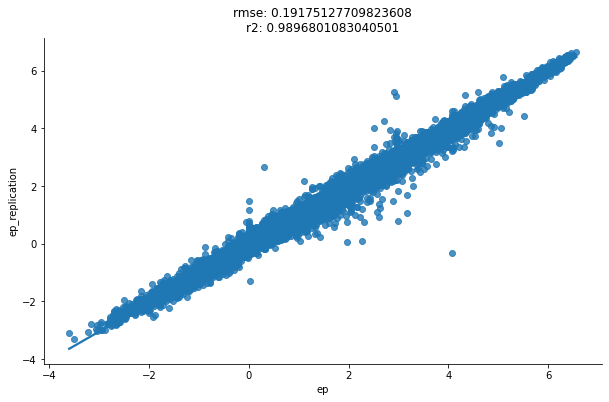

In [ ]:
x = 'ep'
y = 'ep_replication'
rmse = mean_squared_error(df_pred[x], df_pred[y])**0.5
r2 = pearsonr(df_pred[x], df_pred[y])[0]**2
df_plt = df_pred.sample(20000)
fig = plt.figure(figsize=(10,6))
sns.regplot(data=df_plt, x=x, y=y)
plt.title(f"rmse: {rmse}\nr2: {r2}")
sns.despine()
plt.show()

In [ ]:
df_pred.head()

<IPython.core.display.Javascript object>

,play_id,game_id,next_score_target_code,season,half_seconds_remaining,yardline_100,is_home,roof_code,down,ydstogo,era_code,posteam_timeouts_remaining,defteam_timeouts_remaining,fg_pred,no_score_pred,opp_fg_pred,opp_safety_pred,opp_touchdown_pred,safety_pred,touchdown_pred,next_score_target,next_score_target_pred,next_score_target_pred_code,ep,fg_pred_ep,no_score_pred_ep,opp_fg_pred_ep,opp_safety_pred_ep,opp_touchdown_pred_ep,safety_pred_ep,touchdown_pred_ep,ep_replication
0,60,1999_01_ARI_PHI,6,1999,1800.0,77.0,1,3,1.0,10,0,3.0,3.0,0.219381,0.011904,0.179124,0.002779,0.250280,0.003480,0.333053,touchdown,touchdown,6,0.764706,0.658143,0.0,-0.537372,-0.005557,-1.751959,0.006960,2.331368,0.701582
1,82,1999_01_ARI_PHI,6,1999,1800.0,77.0,1,3,2.0,10,0,3.0,3.0,0.201926,0.011628,0.212558,0.003379,0.273516,0.003388,0.293605,touchdown,touchdown,6,0.203138,0.605777,0.0,-0.637675,-0.006757,-1.914612,0.006776,2.055238,0.108747
2,260,1999_01_ARI_PHI,6,1999,1588.0,59.0,1,3,1.0,10,0,3.0,3.0,0.263160,0.014481,0.129380,0.001810,0.184727,0.005637,0.400805,touchdown,touchdown,6,2.043952,0.789479,0.0,-0.388140,-0.003620,-1.293091,0.011275,2.805633,1.921536
3,281,1999_01_ARI_PHI,6,1999,1588.0,52.0,1,3,2.0,3,0,3.0,3.0,0.263726,0.012528,0.110220,0.001363,0.170849,0.006218,0.435096,touchdown,touchdown,6,2.405087,0.791179,0.0,-0.330659,-0.002726,-1.195945,0.012435,3.045671,2.319955
4,305,1999_01_ARI_PHI,6,1999,1588.0,37.0,1,3,1.0,10,0,3.0,3.0,0.326786,0.008939,0.074474,0.000935,0.118477,0.005031,0.465356,touchdown,touchdown,6,3.405015,0.980359,0.0,-0.223423,-0.001871,-0.829342,0.010063,3.257495,3.193282


In [ ]:
text2score = {'fg': 3,
        'no_score': 0,
        'opp_fg': -3,
        'opp_safety': -2,
        'opp_touchdown': -7,
        'safety': 2,
        'touchdown': 7}

merge_feats = ['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       'side_of_field', 'yardline_100', 'game_date',
       'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'game_half', 'quarter_end', 'drive',
       'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo',
       'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun',
       'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble',
       'pass_length', 'pass_location', 'air_yards', 'yards_after_catch',
       'run_location', 'run_gap', 'field_goal_result', 'kick_distance',
       'extra_point_result', 'two_point_conv_result',
       'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout',
       'timeout_team','posteam_score',
       'defteam_score', 'score_differential', 'posteam_score_post',
       'defteam_score_post', 'score_differential_post', 'no_score_prob',
       'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob', 'fg_prob',
       'safety_prob', 'td_prob', 'extra_point_prob',
       'two_point_conversion_prob', 'ep', 'epa', 'passer_player_id', 'passer_player_name',
       'passing_yards', 'receiver_player_id', 'receiver_player_name',
       'receiving_yards', 'rusher_player_id', 'rusher_player_name',
       'rushing_yards', 'scoring_play', 'next_score_team', 'opp']

df_compare = df.loc[:, merge_feats].merge(df_pred.loc[:, ['play_id', 'game_id', 'ep_replication', 'next_score_target']])
df_compare['_game_previous'] = df_compare['game_id'].shift(-1)
df_compare['_ep'] = df_compare['ep_replication'].shift(-1).fillna(0)
df_compare.loc[df_compare['game_id']!=df_compare['_game_previous'], '_ep'] = 0
df_compare['next_score_points'] = df_compare['next_score_target'].map(text2score)
df_compare.loc[df_compare['scoring_play']==1, '_ep'] = df_compare.loc[df_compare['scoring_play']==1, 'next_score_points']
df_compare['posteam_change'] = 0
df_compare.loc[(df_compare['posteam']!=df_compare['posteam'].shift(-1)) & (df_compare['posteam'].notnull()), 'posteam_change'] = 1
df_compare['epa_replication'] = df_compare['_ep'].sub(df_compare['ep_replication'])
df_compare.loc[(df_compare['scoring_play']==0) & (df_compare['posteam_change']==1), 'epa_replication'] = df_compare.loc[(df_compare['scoring_play']==0) & (df_compare['posteam_change']==1), 'ep_replication'].mul(-1).sub(df_compare.loc[(df_compare['scoring_play']==0) & (df_compare['posteam_change']==1), '_ep'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

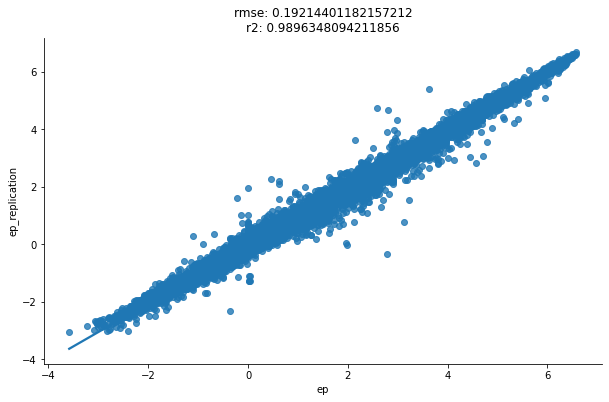

In [ ]:
x = 'ep'
y = 'ep_replication'
_df = df_compare.dropna(subset=[x,y])
rmse = mean_squared_error(_df[x], _df[y])**0.5
r2 = pearsonr(_df[x], _df[y])[0]**2
df_plt = _df.sample(20000)
fig = plt.figure(figsize=(10,6))
sns.regplot(data=df_plt, x=x, y=y)
plt.title(f"rmse: {rmse}\nr2: {r2}")
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

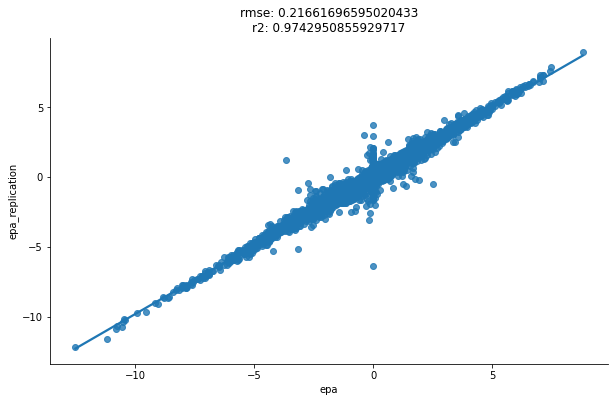

In [ ]:
x = 'epa'
y = 'epa_replication'
_df = df_compare.dropna(subset=[x,y])
rmse = mean_squared_error(_df[x], _df[y])**0.5
r2 = pearsonr(_df[x], _df[y])[0]**2
df_plt = _df.sample(20000)
fig = plt.figure(figsize=(10,6))
sns.regplot(data=df_plt, x=x, y=y)
plt.title(f"rmse: {rmse}\nr2: {r2}")
sns.despine()
plt.show()

In [ ]:
df_rep = df.merge(df_compare.loc[:, ['game_id', 'play_id', 'ep_replication', 'epa_replication']].drop_duplicates())
df_rep.to_csv(f'drive/My Drive/ep-replication/df_rep.csv', index=False)
df_rep.shape

<IPython.core.display.Javascript object>

(890396, 393)

In [ ]:
df_rep = pd.read_csv(f'drive/My Drive/ep-replication/df_rep.csv')
df_rep['epa_diff'] = df_rep['epa_replication'].sub(df_rep['epa'])
df_rep.shape

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (36,37,49,179,180,182,183,189,190,193,194,195,196,205,206,207,208,209,210,211,212,213,214,218,219,220,233,234,235,236,237,238,248,249,253,254,255,260,262,263,266,267,268,269,283,284,292,293,294,295,296,299,301,302,303) have mixed types.Specify dtype option on import or set low_memory=False.



(890396, 394)

In [ ]:
_df = df_rep.loc[:, ['passer_player_id', 'passer_player_name']].drop_duplicates(subset=['passer_player_id'],keep='last')
df_agg = (df_rep
          .loc[:,
               ['season', 'posteam', 'passer_player_id',
                'epa', 'epa_replication', 'epa_diff']]
          .groupby(['season', 'posteam', 'passer_player_id'],
                   as_index=False)
          .sum())
df_agg = _df.merge(df_agg)
df_agg.shape

<IPython.core.display.Javascript object>

(2387, 7)

In [ ]:
df_agg.sort_values('epa_diff', ascending=False).head(10)

<IPython.core.display.Javascript object>

,passer_player_id,passer_player_name,season,posteam,epa,epa_replication,epa_diff
774,00-0003739,D.Culpepper,2000,MIN,83.930443,124.071810,40.141367
949,00-0011022,D.McNabb,2004,PHI,122.186251,159.894146,37.707895
174,00-0001218,S. Beuerlein,1999,CAR,60.499080,96.983321,36.484241
857,00-0005106,B.Favre,2001,GB,54.593040,90.535398,35.942358
1083,00-0000865,C.Batch,2000,DET,-76.219087,-40.786276,35.432811
793,00-0017200,K.Warner,2001,LA,120.952455,153.669598,32.717143
1457,00-0021429,C.Palmer,2013,ARI,3.298129,35.934518,32.636389
399,00-0005363,D.Flutie,2000,BUF,23.225864,55.537812,32.311948
1357,00-0010346,P.Manning,2001,IND,9.579157,41.556135,31.976978
856,00-0005106,B.Favre,2000,GB,-0.050904,31.820326,31.871230


In [ ]:
df_agg.sort_values('epa_diff', ascending=False).tail(10)

<IPython.core.display.Javascript object>

,passer_player_id,passer_player_name,season,posteam,epa,epa_replication,epa_diff
2286,00-0033106,J.Goff,2018,LA,102.485507,95.766945,-6.718562
1712,00-0022803,E.Manning,2018,NYG,21.316868,14.418465,-6.898402
2313,00-0022924,B.Roethlisberger,2018,PIT,119.183044,111.711059,-7.429194
2020,00-0034343,J.Rosen,2018,ARI,-156.008602,-163.610111,-7.601509
2088,00-0033077,D.Prescott,2018,DAL,19.134441,11.389969,-7.744471
2250,00-0026498,M.Stafford,2018,DET,4.905090,-3.991417,-8.896507
2160,00-0031280,D.Carr,2018,LV,-7.201374,-17.107081,-9.905707
1630,00-0029668,A.Luck,2018,IND,75.651646,65.489432,-10.162214
1930,00-0027939,C.Newton,2018,CAR,27.131045,15.855998,-11.275047
2295,00-0034855,B.Mayfield,2018,CLE,22.954193,11.184049,-11.770144


In [ ]:
fig = plt.figure(figsize=(10,6))
sns.lineplot(data=df_plt, x='yardline_100', y='n_plays', hue=target, lw=4)
plt.gca().invert_xaxis()
plt.show()

fig = plt.figure(figsize=(10,6))
sns.lineplot(data=df_plt, x='yardline_100', y='n_plays_pred', hue=target, lw=4)
plt.gca().invert_xaxis()
plt.show()

<IPython.core.display.Javascript object>

ValueError: ignored

<Figure size 720x432 with 0 Axes>